In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

try:
    import hypernetx as hnx
    import hypernetx.algorithms.contagion as contagion
except ImportError:
    print("Installing HyperNetX and contagion-related dependencies.........")
    !pip install hypernetx celluloid --quiet 2> /dev/null
    print("Installation complete; please rerun this cell in order for the rest of the cells to use HyperNetX.")
    exit()

import shutup
shutup.mute_warnings()

## s-centrality metrics

<img src="../images/s-width.png" width="600" align="left" style="margin-right:10px">

Hypergraph metrics generalize traditional graph metrics by including parameters for edge size and edge intersection size. In the figure there are two hypergraphs. Each illustrates an edge path of length 2, connecting Blue, Orange, and Green. The path in hypergraph I. has *width* 1, while the path in hypergraph II. has *width* 3. The width of an edge path is the size of the smallest intersection.

While graphs use shortest paths to define a distance metric, hypergraphs can stipulate a width parameter **s** to the shortest path. The edge s-distance between two edges is the shortest path of width **s** between the edges. The s-distance between two nodes has an analogous definition replacing the size of edge intersection with the number of shared edges between consecutive nodes. Because the intuition around edge s-distance seems more natural than node distance we will refer to s-distance in terms of edges unless stated otherwise and use the dual of the hypergraph when considering the s-distance between nodes.

For a detailed exposition of s-distance metrics and hypergraph walks in general see: 
<a href="https://doi.org/10.1140/epjds/s13688-020-00231-0">Aksoy, S.G., Joslyn, C., Ortiz Marrero, C. et al. Hypernetwork science via high-order hypergraph walks. EPJ Data Sci. 9, 16 (2020).</a>   

In this tutorial we will provide just enough information to provide some intuition about the s-parameter and s-metrics. As described above, s-distance is a true metric on the edges of a hypergraph. We use s-distance to define s-connectedness, s-centrality as well as other analogs to well known graph concepts.  



## Example
We illustrate the s-centrality metrics on a simple example. We construct a hypergraph $H$ with 6 nodes and 5 edges and compute the s-centralities for the edges in $H$.

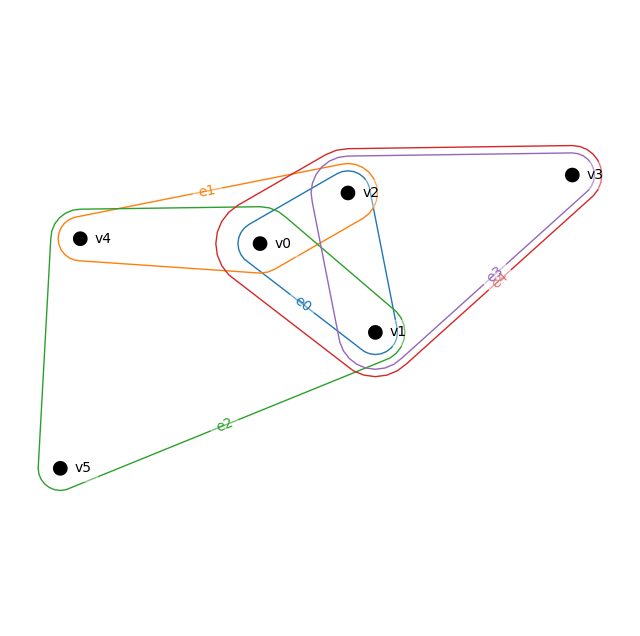

In [2]:
class SixByFive():
    """Example hypergraph with 6 nodes and 5 edges"""
    def __init__(self):
        mat = np.array([[1, 1, 1, 0, 0, 0], [1, 0, 1, 0, 1, 0], [1, 1, 0, 0, 1, 1], [0, 1, 1, 1, 0, 0], [1, 1, 1, 1, 0, 0]]).transpose()
        self.hypergraph = hnx.Hypergraph.from_numpy_array(mat)

H = SixByFive().hypergraph
hnx.draw(H)


### Edge s-line graphs for s=1,2,3

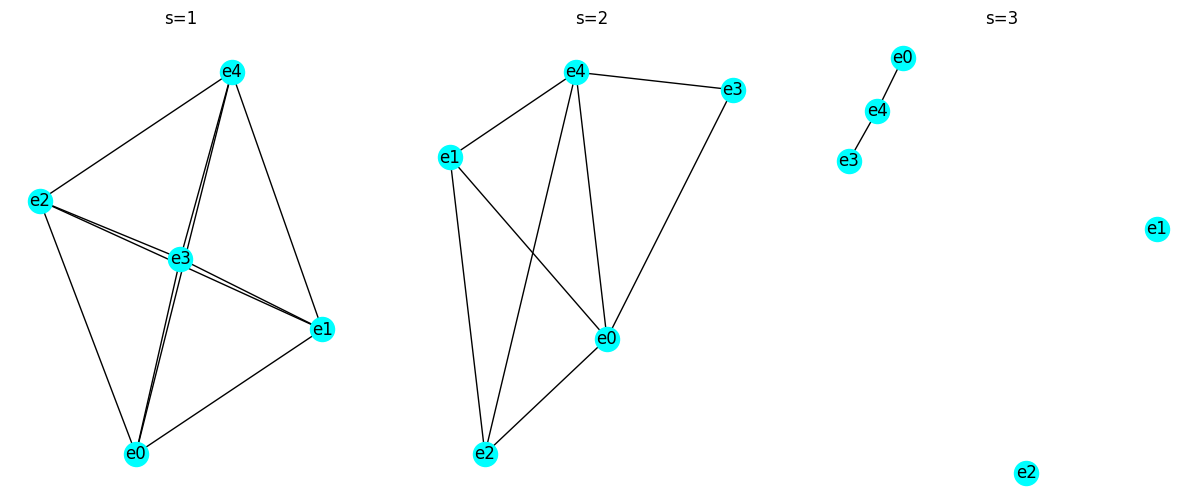

In [3]:
fig,ax = plt.subplots(1,3,figsize=(15,6))
A = dict()
g = dict()
for i in range(1,4):
    A[i],names = H.edge_adjacency_matrix(s=i,index=True)
    A[i] = A[i].todense()
    g[i] = H.get_linegraph(s=i)  ## corresponding line graph
    ax[i-1].set_title(f's={i}')
    nx.draw(g[i],ax=ax[i-1],with_labels=True, node_color='cyan');


**Note the differences between the three linegraphs. The 1-linegraph is uniform so all vertices have equal centrality. The 2-linegraph has two vertices, e0 and e4, that are minimally central to all other vertices and 3 vertices that are more removed. The 3-linegraph has only 1 vertex, e4, with any significant centrality in the linegraph. These differences are noted in the s-centrality metrics below.**

## s-closeness centrality - 
If $u$ is a vertex in one of the s-line graphs above, the s-closeness centrality is computed on each of the connected components

$V$ = the set of vertices in the linegraph.  
$n = |V|$
$$C(u) = \frac{n - 1}{\sum_{v \neq u \in V} d(v, u)}$$


In [4]:
for s in range(1,4):
    print(f'The {s}-closeness centrality of the edges in hypergraph H is:')
    try:
        d = hnx.s_closeness_centrality(H,s=s)
        for e in H.edges:
            print(f'{e}: {d[e]}')
        print('\n')
    except Exception as ex:
        print(ex)

The 1-closeness centrality of the edges in hypergraph H is:
e0: 1.0
e1: 1.0
e2: 1.0
e4: 1.0
e3: 1.0


The 2-closeness centrality of the edges in hypergraph H is:
e0: 1.0
e1: 0.8
e2: 0.8
e4: 1.0
e3: 0.6666666666666666


The 3-closeness centrality of the edges in hypergraph H is:
'e0'


## s-harmonic centrality - 

The denormalized reciprocal of the harmonic mean of all distances from $u$ to all other vertices.  
$V$ = the set of vertices in the linegraph.
$$C(u) = \sum_{v \neq u \in V} \frac{1}{d(v, u)}$$

Normalized this becomes:
$$C(u) = \sum_{v \neq u \in V} \frac{1}{d(v, u)}\cdot\frac{2}{(n-1)(n-2)}$$
where $n$ is the number vertices.

In [5]:
## 
for s in range(1,4):
    print(f'The {s}-harmonic closeness centrality of the edges in hypergraph H is:')
    try:
        d = hnx.s_harmonic_centrality(H,s=s, normalized=True)
        for e in H.edges:
            print(f'{e}: {d[e]}')
        print('\n')
    except Exception as ex:
        print(ex)

The 1-harmonic closeness centrality of the edges in hypergraph H is:
e0: 0.6666666666666666
e1: 0.6666666666666666
e2: 0.6666666666666666
e4: 0.6666666666666666
e3: 0.6666666666666666


The 2-harmonic closeness centrality of the edges in hypergraph H is:
e0: 0.6666666666666666
e1: 0.5833333333333333
e2: 0.5833333333333333
e4: 0.6666666666666666
e3: 0.5


The 3-harmonic closeness centrality of the edges in hypergraph H is:
e0: 0.25
e1: 0.0
e2: 0.0
e4: 0.3333333333333333
e3: 0.25




## s-eccentricity -
The length of the longest shortest path from a vertex $u$ to every other vertex in the linegraph.  
$V$ = set of vertices in the linegraph
$$ \text{s-ecc}(u) = \text{max}\{d(u,v): v \in V\} $$

In [6]:
## Max s-distance from every other edge
for s in range(1,4):
    print(f'The {s}-eccentricity of the edges in hypergraph H is:')
    try:
        d = hnx.s_eccentricity(H,s=s)
        for e in H.edges:
            print(f'{e}: {d[e]}')
        print('\n')
    except Exception as ex:
        print(ex)
        

The 1-eccentricity of the edges in hypergraph H is:
e0: 1
e1: 1
e2: 1
e4: 1
e3: 1


The 2-eccentricity of the edges in hypergraph H is:
e0: 1
e1: 2
e2: 2
e4: 1
e3: 2


The 3-eccentricity of the edges in hypergraph H is:
Found infinite path length because the graph is not connected


## s-betweenness centrality
The centrality of edge to all shortest s-edge paths
$V$ = the set of vertices in the linegraph.  
$\sigma(s,t)$ = the number of shortest paths between vertices $s$ and $t$.  
$\sigma(s, t|u)$ = the number of those paths that pass through vertex $u$
$$c_B(u) =\sum_{s \neq t \in V} \frac{\sigma(s, t|u)}{\sigma(s, t)}$$

In [7]:
for s in range(1,4):
    print(f'The {s}-betweenness of the edges in hypergraph H is:')
    try:
        d = hnx.s_betweenness_centrality(H, s=s, normalized=False)
        for e in H.edges:
            print(f'{e}: {d[e]}')
        print('\n')
    except Exception as ex:
        print(ex)
        


The 1-betweenness of the edges in hypergraph H is:
e0: 0.0
e1: 0.0
e2: 0.0
e4: 0.0
e3: 0.0


The 2-betweenness of the edges in hypergraph H is:
e0: 1.0
e1: 0.0
e2: 0.0
e4: 1.0
e3: 0.0


The 3-betweenness of the edges in hypergraph H is:
'e0'
